In [ ]:
!pip install segyio
!pip install segmentation-models-3D
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [ ]:
import segyio
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_3D as sm
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap

Segmentation Models: using `tf.keras` framework.


In [ ]:
seismic = segyio.tools.cube('/content/drive/MyDrive/APGCE/a_seismic.segy')

In [ ]:
facies = segyio.tools.cube('/content/drive/MyDrive/APGCE/a_facies.segy')

In [ ]:
output = np.where(facies>0.0, 1, 0) #cut the value to binary classification, 0 for non-facies/background and 1 for facies

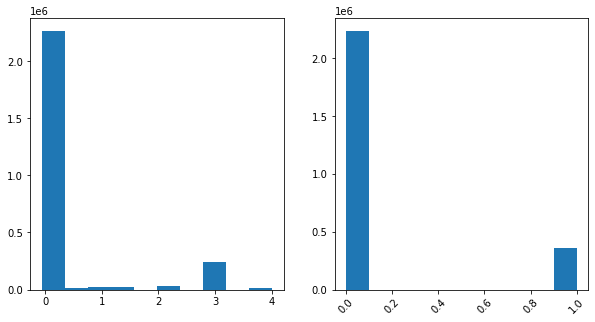

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(facies.reshape(-1,1), bins=10)
ax[1].hist(output.reshape(-1,1), bins=10)
plt.setp(ax[1].get_xticklabels(), rotation=45)
plt.show()

In [ ]:
with segyio.open('/content/drive/MyDrive/APGCE/a_seismic.segy', "r") as f:
  print(f.ilines)
  print(f.xlines)
  print(f.samples)



[ 344  345  346 ... 1370 1371 1372]
[ 701  702  703 ... 3194 3195 3196]
[1600. 1602. 1604. 1606. 1608. 1610. 1612. 1614. 1616. 1618. 1620. 1622.
 1624. 1626. 1628. 1630. 1632. 1634. 1636. 1638. 1640. 1642. 1644. 1646.
 1648. 1650. 1652. 1654. 1656. 1658. 1660. 1662. 1664. 1666. 1668. 1670.
 1672. 1674. 1676. 1678. 1680. 1682. 1684. 1686. 1688. 1690. 1692. 1694.
 1696. 1698. 1700. 1702. 1704. 1706. 1708. 1710. 1712. 1714. 1716. 1718.
 1720. 1722. 1724. 1726. 1728. 1730. 1732. 1734. 1736. 1738. 1740. 1742.
 1744. 1746. 1748. 1750. 1752. 1754. 1756. 1758. 1760. 1762. 1764. 1766.
 1768. 1770. 1772. 1774. 1776. 1778. 1780. 1782. 1784. 1786. 1788. 1790.
 1792. 1794. 1796. 1798. 1800.]


In [ ]:
# facies.shape

In [ ]:
#transofrm the seismic with facies sampling (10 inline)
input_seismic = []
for i in np.arange(344, 1374, 10):
  for j in np.arange(701, 3201, 10):
    idx_i = np.where(f.ilines==i)
    idx_j = np.where(f.xlines==j)
    # print(seismic[idx_i, idx_j])
    input_seismic.append(seismic[idx_i,idx_j])
input_seismic = np.reshape(input_seismic, (output.shape))

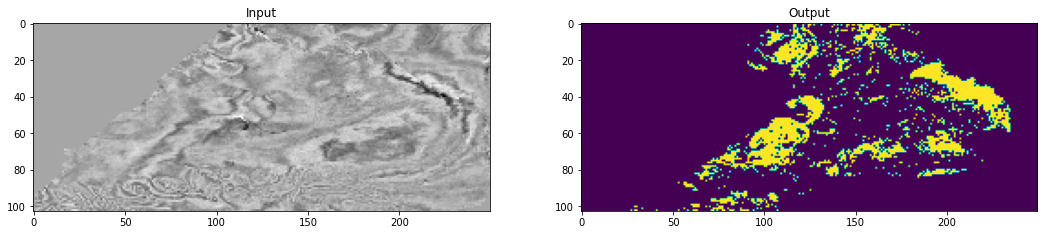

In [ ]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(input_seismic[:,:, 4], cmap='Greys')
ax1.set_title('Input')
ax2.imshow(output[:,:, 4])
ax2.set_title('Output')
plt.show()

In [ ]:
#turn into model shape
input_seismic = input_seismic[:96, :224, :96]
output_facies = output[:96, :224, :96]

In [ ]:
full_i = patchify(input_seismic, (32, 32, 32), step=32)
full_o = patchify(output_facies, (32, 32, 32), step=32)

full_i = np.reshape(full_i, (full_i.shape[0]*full_i.shape[1]*full_i.shape[2], full_i.shape[3], full_i.shape[4], full_i.shape[5]))
full_o = np.reshape(full_o, (full_o.shape[0]*full_o.shape[1]*full_o.shape[2], full_o.shape[3], full_o.shape[4], full_o.shape[5]))

print(input_seismic.shape)
print(full_i.shape)

(96, 224, 96)
(63, 32, 32, 32)


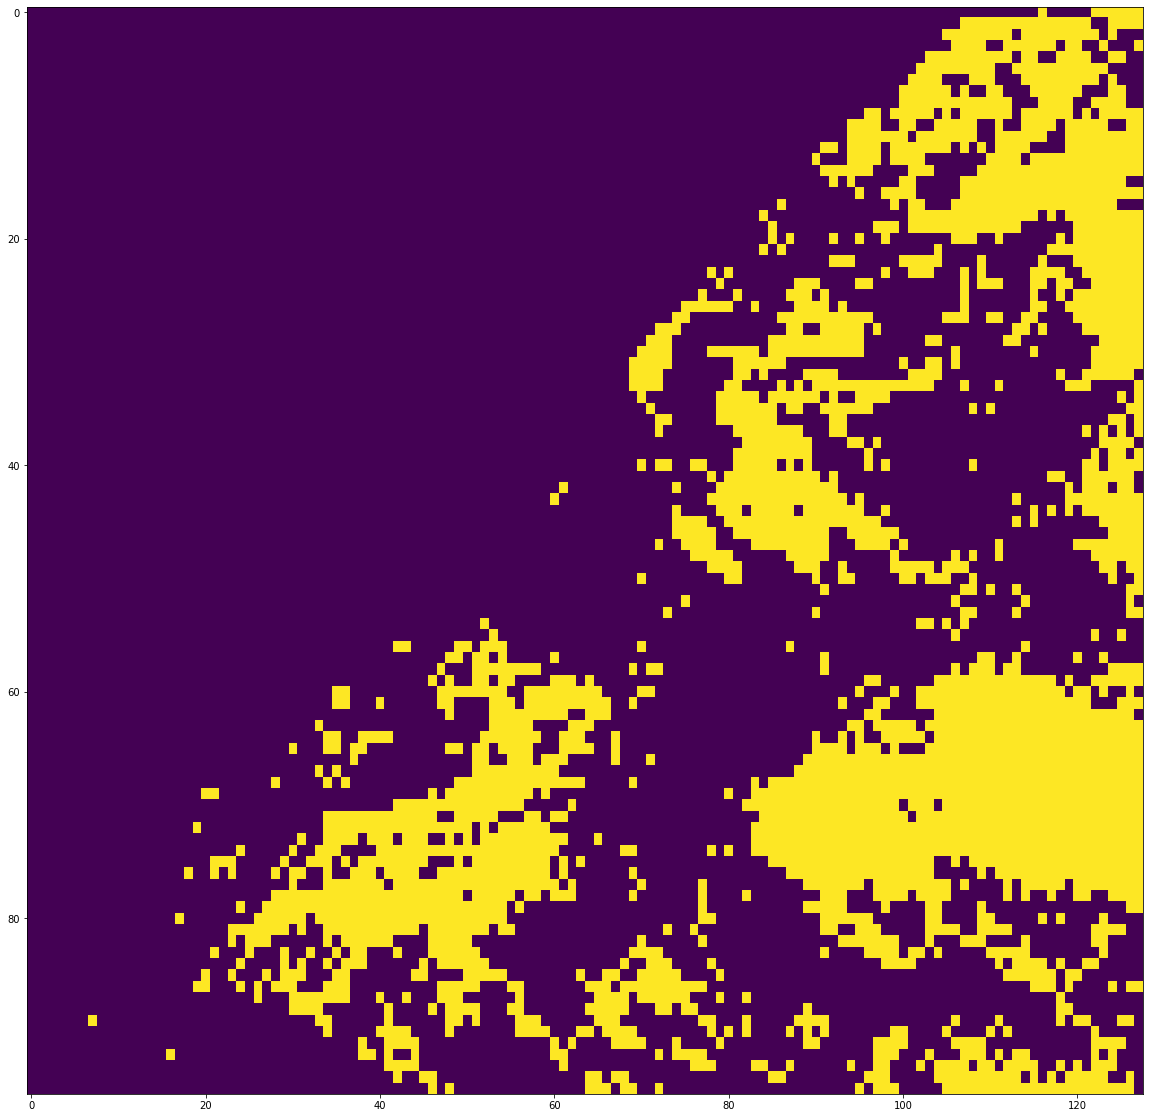

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(output_facies[:128, :128, 20], aspect='auto')
# ax[1].imshow(output_facies[:128, :128, 20])


In [ ]:
train_img = np.stack((full_i,)*3, axis=-1)
train_mask = np.expand_dims(full_o, axis=4)


train_mask_cat = tf.keras.utils.to_categorical(train_mask, num_classes=2)


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.20, random_state = 0)

print(X_train.shape)
print(X_test.shape)

(50, 32, 32, 32, 3)
(13, 32, 32, 32, 3)


In [ ]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'resnet50'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'sigmoid'
patch_size = 32
n_classes = 2
channels=3

LR = 0.001
optim = 'Adam'

# dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25])) 
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]


In [ ]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [ ]:
model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = Adam(learning_rate=LR), loss=sm.losses.binary_focal_dice_loss, metrics=metrics)
print(model.summary())

185466880/185458584 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 32, 32, 32,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, 32, 32, 32,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, 38, 38, 38,   0          ['bn_data[0][0]']                
                         

In [ ]:
# es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# mc = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/data/base_model_angsi_facies.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
#Fit the model
history = model.fit(X_train_prep, 
                    y_train,
                    batch_size=8, 
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_test_prep, y_test))

Epoch 1/1000
7/7 [==============================] - 29s 839ms/step - loss: 0.5939 - iou_score: 0.3642 - f1-score: 0.4858 - val_loss: 1.7161 - val_iou_score: 0.4003 - val_f1-score: 0.4478
Epoch 2/1000
7/7 [==============================] - 1s 188ms/step - loss: 0.5317 - iou_score: 0.4246 - f1-score: 0.5426 - val_loss: 1.7321 - val_iou_score: 0.4070 - val_f1-score: 0.4519
Epoch 3/1000
7/7 [==============================] - 1s 189ms/step - loss: 0.5156 - iou_score: 0.4459 - f1-score: 0.5669 - val_loss: 4.6038 - val_iou_score: 0.4597 - val_f1-score: 0.5372
Epoch 4/1000
7/7 [==============================] - 1s 189ms/step - loss: 0.5019 - iou_score: 0.4567 - f1-score: 0.5802 - val_loss: 5.8265 - val_iou_score: 0.4832 - val_f1-score: 0.5558
Epoch 5/1000
7/7 [==============================] - 1s 190ms/step - loss: 0.4832 - iou_score: 0.4637 - f1-score: 0.5820 - val_loss: 6.5500 - val_iou_score: 0.3924 - val_f1-score: 0.4983
Epoch 6/1000
7/7 [==============================] - 1s 191ms/step - l

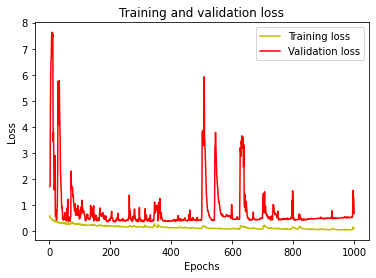

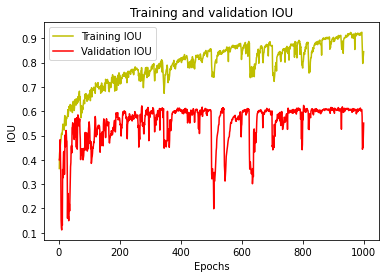

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#Predict on the test data
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)

#Predict on the train data
y_pred_train=model.predict(X_train)
y_pred_train_argmax=np.argmax(y_pred_train, axis=4)
y_train_argmax = np.argmax(y_train, axis=4)

In [ ]:
IOU_keras_train = MeanIoU(num_classes=n_classes)  
IOU_keras_train.update_state(y_train_argmax, y_pred_train_argmax)
print("Mean IoU Train=", IOU_keras_train.result().numpy())

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU Test=", IOU_keras.result().numpy())

Mean IoU Train= 0.77159905
Mean IoU Test= 0.5659922


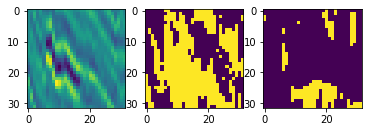

In [ ]:
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
randil = np.random.randint(0, len(X_test), 1)[0]
ax1.imshow(X_test[randil, 29, : , :, 1].T)
ax2.imshow(y_test_argmax[randil, 29, : , :].T)
ax3.imshow(y_pred_argmax[randil, 29, : , :].T)

In [ ]:
y_train_arr, y_pred_train_arr = np.reshape(y_train_argmax, (50*32*32*32)), np.reshape(y_pred_train_argmax, (50*32*32*32))
y_test_arr, y_pred_arr = np.reshape(y_test_argmax, (13*32*32*32)), np.reshape(y_pred_argmax, (13*32*32*32))

In [ ]:

print('Train Report')
print(classification_report(y_train_arr, y_pred_train_arr))
print('Test Report')
print(classification_report(y_test_arr, y_pred_arr))

Train Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96   1392374
           1       0.88      0.67      0.76    246026

    accuracy                           0.94   1638400
   macro avg       0.91      0.83      0.86   1638400
weighted avg       0.93      0.94      0.93   1638400

Test Report
              precision    recall  f1-score   support

           0       0.90      0.98      0.94    370335
           1       0.70      0.28      0.40     55649

    accuracy                           0.89    425984
   macro avg       0.80      0.63      0.67    425984
weighted avg       0.87      0.89      0.87    425984



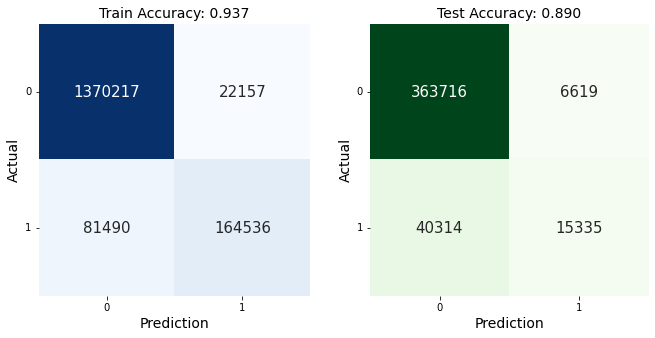

In [ ]:
plt.figure(figsize=(11, 5))
labels = np.unique(y_train_arr)
plt.subplot(121)
cm = confusion_matrix(y_train_arr, y_pred_train_arr, labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Train Accuracy: {accuracy_score(y_train_arr, y_pred_train_arr):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')
plt.subplot(122)
cm = confusion_matrix(y_test_arr, y_pred_arr, labels=labels)
sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Test Accuracy: {accuracy_score(y_test_arr, y_pred_arr):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')
plt.show()

In [ ]:
input_seismic.shape

(96, 224, 96)

In [ ]:
# val_input = segyio.tools.cube('/content/drive/MyDrive/APGCE/a_seismic.segy')[:1024, :, :96]
val_input = input_seismic

In [ ]:
patches = patchify(val_input, (32, 32, 32), step=32)
print(val_input.shape)
print(patches.shape)

(96, 224, 96)
(3, 7, 3, 32, 32, 32)


In [ ]:
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)

In [ ]:
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(63, 32, 32, 32)


In [ ]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(3, 7, 3, 32, 32, 32)


In [ ]:
reconstructed_seismic = unpatchify(predicted_patches_reshaped, val_input.shape)
print(reconstructed_seismic.shape)

(96, 224, 96)


In [ ]:
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,0,ncolors)
color_array[255:256] = [1, 0.0, 0., 1]
map_object = LinearSegmentedColormap.from_list(name='facies',colors=color_array)
plt.register_cmap(cmap=map_object)

In [ ]:
with segyio.open('/content/drive/MyDrive/APGCE/a_seismic.segy') as f:
    iline = f.ilines
    xline = f.xlines
    twt = f.samples

In [ ]:
vm = np.percentile(val_input, 99)

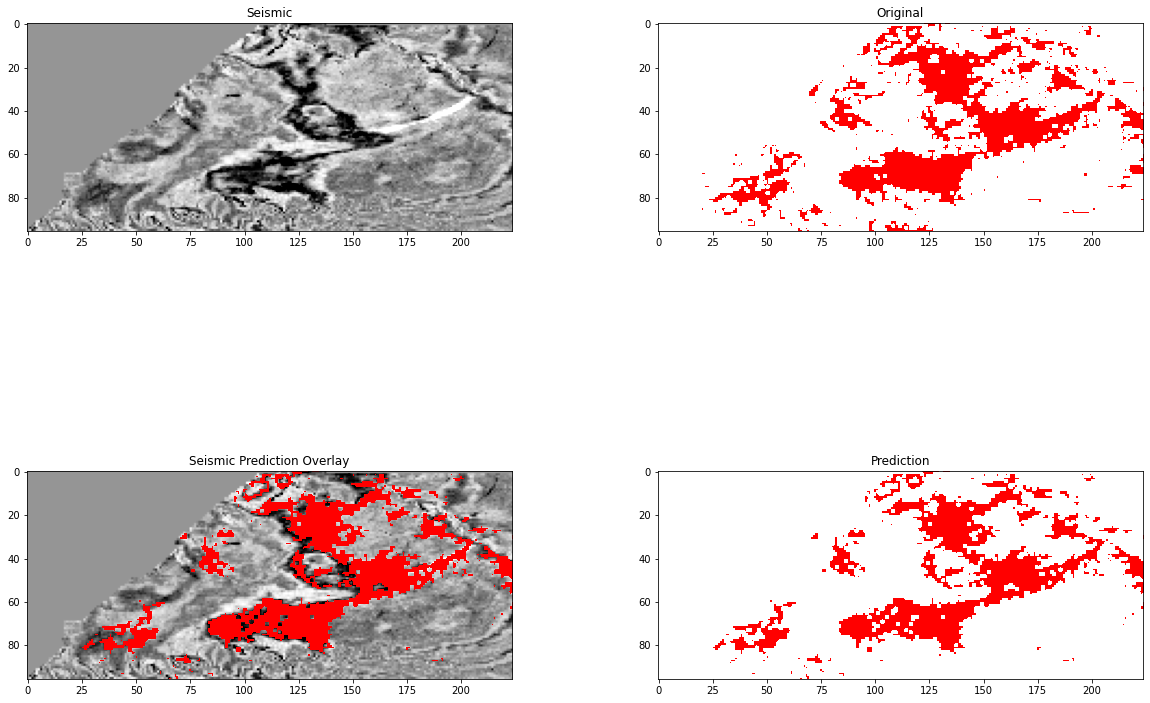

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))
# ax1 = plt.subplot(411)
# ax2 = plt.subplot(412)
# ax3 = plt.subplot(423)
# ax4 = plt.subplot(424)


axs[0,0].imshow(val_input[:, :, 20], cmap='Greys', vmin=-vm, vmax=vm)
axs[0,1].imshow(output_facies[:,:,20], cmap='facies')
axs[1,0].imshow(val_input[:, :, 20], cmap='Greys', vmin=-vm, vmax=vm)
axs[1,0].imshow(reconstructed_seismic[:, :, 20], cmap='facies')
axs[1,1].imshow(reconstructed_seismic[:, :, 20],  cmap='facies')

axs[0,0].set_title('Seismic')
axs[0,1].set_title('Original')
axs[1,0].set_title('Seismic Prediction Overlay')
axs[1,1].set_title('Prediction')
plt.subplots_adjust(wspace=0.3, hspace=-0.3)
plt.show()